# Perkenalan

**Nama: Muhamad Fikri Mumtaz**

**Batch: HCK-004**

----

**Background Problem:**



Perusahaan bernama PT.Green Flow Indonesia yang berjalan dibidang perkebunan merekrut saya untuk membuat sebuat model kecerdasan pintar (AI) yang dapat secara otomatis melakukan klasifikasi kesehatan perkebunan buah anggur mereka yang dilihat dari kondisi daun tumbuhan tersebut.

**Problem Statement**

Membuat Model Klasifikasi Supervised Deep-Learning dengan tema kesehatan tumbuhan Anggur berdasarkan kondisi daun tumbuhan Anggur.

**Objective**

- Apa saja jenis kondisi pada tumbuhan Anggur?
- Seberapa persen tingkat confidence pada model yang dibuat?
- Apa impact yang ditimbulkan setelah model tersebut dibuat?
- Apakah model yang dibuat dapat digunakan pada gambar yang terdapat latar belakang?

----

# Important Library

In [81]:
# Basic Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import plotly.express as px
import joblib

# Model Selection
import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split

# Tensorflow untuk Model Deep-Learning CNN
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img, array_to_img, image_dataset_from_directory
from keras.layers import Dense

In [51]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else: 
   print("Please install GPU version of TF")

print(tf.__version__)

Default GPU Device:/device:GPU:0
2.10.0


In [52]:
pd.set_option('display.max_columns', None)

# Data Loading

Directory path folder dataset yang akan digunakan

In [53]:
train_folder = r'D:\Hacktiv8\Milestone\Milestone 5\Original Data\train'
test_folder = r'D:\Hacktiv8\Milestone\Milestone 5\Original Data\test'

Pathlib bekerja seperti halnya pd.read_csv pada pandas yaitu membaca data dari sebuah path yang telah terdefine

In [54]:
import pathlib
data_dir_train = pathlib.Path(train_folder)
data_dir_test = pathlib.Path(test_folder)

filepath dan labels membaca dan menidentifikasi dataset gambar pada path tersebut dan labels membaca label folder pada path tersebut

In [55]:
filepath = list(data_dir_train.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

filepath = pd.Series(filepath, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
data_df = pd.concat([filepath, labels], axis=1)

In [56]:
data_df

,Filepath,Label
0,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Black Rot
1,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Black Rot
2,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Black Rot
3,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Black Rot
4,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Black Rot
...,...,...
7217,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Leaf Blight
7218,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Leaf Blight
7219,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Leaf Blight
7220,D:\Hacktiv8\Milestone\Milestone 5\Original Dat...,Leaf Blight


Terlihat pada kolom diatas terdapat Filepath dan Label yang telah terdefinisi

In [57]:
Label_Total = data_df['Label'].value_counts()
Label_Total.head(4)

Label
ESCA           1920
Black Rot      1888
Leaf Blight    1722
Healthy        1692
Name: count, dtype: int64

----

# Exploratory Data Analyst

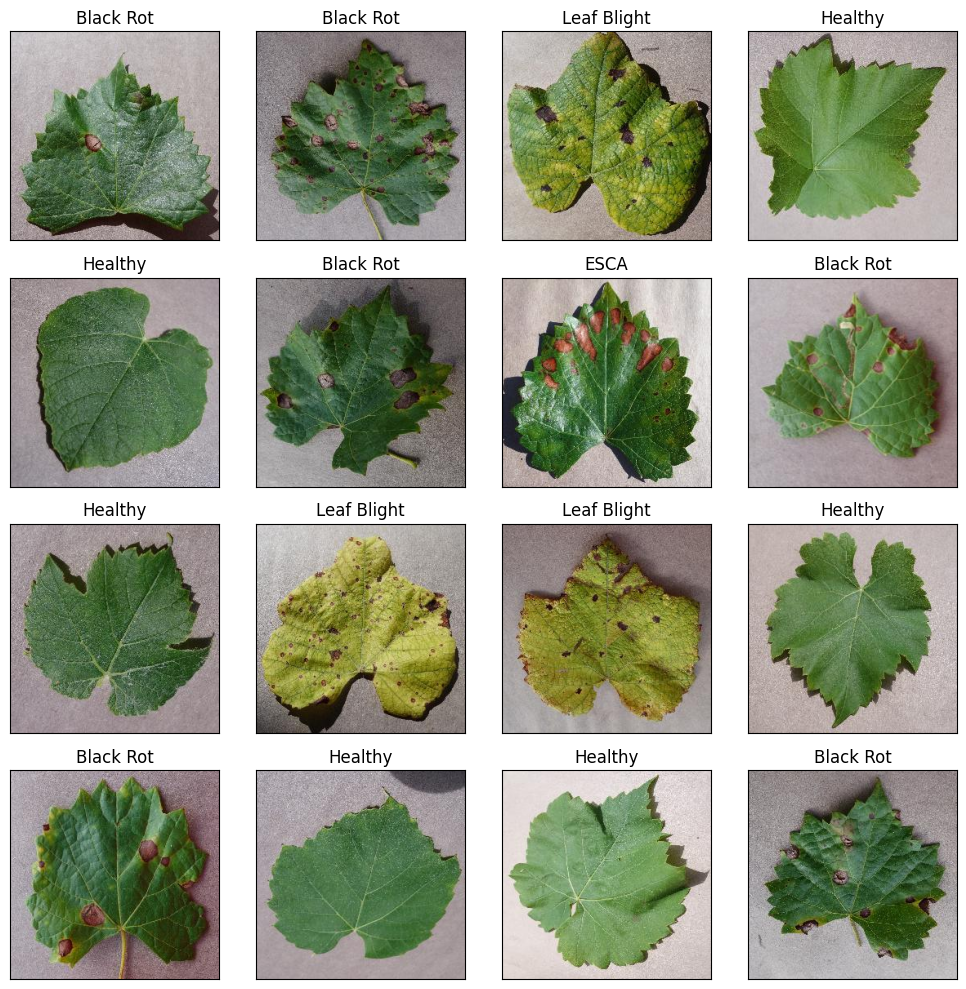

In [58]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(data_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data_df.Filepath[random_index[i]]))
    ax.set_title(data_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

Terlihat sampel gambar pada dataset yang berisikan seluruh label klasifikasi seperti klasifikasi ESCA, Healthy, Leaf Blight, dan Black Rot.

Pada gambar diatas juga terlihat bahwa semua gambar diatas memposisikan objek ditengah gambar dan memiliki latar belakang abu-abu.

In [59]:
fig = go.Figure(go.Bar(
            x=Label_Total.values,
            y=Label_Total.index,
            orientation='h'))

fig.update_layout(title='Data Distribution in Bars',font_size=15,title_x=0.45)


fig.show()

Terlihat pada plot diatas distribusi data kategorikal tersebut tidak sama atau imbalance dengan Kategori ESCA memiliki data sebanyak 1920 dan Kategori Healthy dengan data sebanyak 1692.

In [60]:
fig=px.pie(Label_Total.head(4),values= 'count', names=data_df['Label'].unique(),hole=0.5)
fig.update_layout(title='Data Distribution of Data',font_size=15,title_x=0.45,annotations=[dict(text='Grape Disease',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

Pada Plot pie chart diatas terlihat bahwa walaupun data tersebut imbalance namun tidak terlihat signifikan perbedaannya.

# Feature Engineer

set lebar dan tinggi gambar serta batch size yang akan digunakan untuk pemodelan

In [61]:
IMG_WIDTH=300
IMG_HEIGHT=300
batch_size=32

Membuat data train untuk pemodelan dengan lebar, tinggi, dan batch size gambar yang telah ditentukan sebelumnya. 
Membuat validation split sebagai data validasi.

In [62]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split= 0.2,
    subset='training',
    seed=42,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size= batch_size
)

Found 7222 files belonging to 4 classes.
Using 5778 files for training.


Data Validasi merupakan 20% data dari train folder

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    subset='validation',
    validation_split= 0.2,
    seed=42,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size= batch_size,
    shuffle=False
)

Found 7222 files belonging to 4 classes.
Using 1444 files for validation.


Test data digunakan sebagai model prediction

In [64]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    seed=42,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size= batch_size,
    shuffle=False
)

Found 1805 files belonging to 4 classes.


In [65]:
class_names = train_ds.class_names
print(class_names)

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']


Kelas Klasifikasi pada dataset ini ialah Black rot, ESCA, Healthy, dan Leaf Blight.

In [66]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


Data Train memiliki 32 batch image size, 300x300 image size, dan 3 saluran warna.

Data Train memiliki 32 batch label size.

In [67]:
list_class= train_ds.class_names
nama_class= 'Black Rot'
class_index= list_class.index(nama_class)
print(class_index) #class normal labelnya adalah 0

0


Kelas Klasifikasi Black Rot memiliki kelas index 0

Mari pastikan untuk menggunakan buffered prefetching sehingga Anda dapat menghasilkan data dari disk tanpa I/O menjadi pemblokiran. Ini adalah dua metode penting yang harus Anda gunakan saat memuat data.

Dataset.cache() menyimpan gambar di memori setelah dimuat dari disk selama epoch pertama. Ini akan memastikan set data tidak menjadi hambatan saat melatih model Anda. Jika dataset terlalu besar untuk masuk ke dalam memori, Anda juga dapat menggunakan metode ini untuk membuat cache on-disk yang berkinerja baik.

In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Nilai saluran RGB berada dalam rentang [0, 255]. Ini tidak ideal untuk jaringan saraf; secara umum Anda harus berusaha membuat nilai input Anda kecil. Di sini, Anda akan menstandarkan nilai agar berada dalam rentang [0, 1] dengan menggunakan lapisan Rescaling.

In [69]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
normalized_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9655325


# Model Training

Model training menggunakan activation relu dengan hidden layer sebanyak 8 layer dengan hidden layer pertama menggunakan layer convolution 2D sebanyak 16, 32, dan 64 neural dengan 3 warna RGB, lalu dilakukan maxpooling 2D. Setelah itu dilakukan Flatten dan ditambah dengan layer dense sebanyak 128 neural.

Layer Output menggunakan softmax karena memiliki Kelas Klasifikasi lebih dari 2 sehingga Outputnya adalah probabilitas.

Model menggunakan optimizer Adamax dengan metrik accuracy.

- Sequential Convolution2D model:
    Model Sequential Convolution2D adalah jenis model neural network yang digunakan untuk memproses data gambar. Model ini terdiri dari beberapa layer konvolusi yang secara bertahap memperkecil dimensi gambar, dan kemudian dihubungkan ke beberapa layer Dense untuk klasifikasi akhir.

- Activation Relu:
    Activation ReLU adalah jenis aktivasi non-linear yang digunakan dalam neural network. ReLU merupakan singkatan dari Rectified Linear Unit dan merupakan fungsi matematika sederhana yang menghasilkan output positif jika input lebih besar dari nol, dan output nol jika input lebih kecil dari nol.

- Maxpooling2D:
    Maxpooling2D adalah jenis operasi yang digunakan dalam neural network untuk memperkecil dimensi data gambar. Operasi ini mengambil nilai maksimum dari setiap wilayah pada gambar dan mengembalikan output terkecil.

- Flatten:
    Flatten adalah jenis layer dalam neural network yang digunakan untuk mengubah data berdimensi tinggi seperti data gambar menjadi data berdimensi rendah seperti vektor. Hal ini diperlukan untuk menghubungkan layer Dense dengan layer konvolusi dalam model Sequential Convolution2D.

- Layer.Dense():
    Layer Dense adalah jenis layer dalam neural network yang merupakan layer fully connected atau layer yang terhubung secara penuh ke setiap node pada layer sebelumnya. Layer ini digunakan untuk klasifikasi akhir dalam model Sequential Convolution2D

- Optimizer Adamax adalah jenis optimizer yang digunakan dalam pelatihan model neural network. Optimizer ini menggunakan algoritma  pengoptimalan adaptif berbasis momentum untuk menemukan nilai optimal dari parameter-model yang meminimalkan fungsi kerugian (loss function) selama proses pelatihan. Adamax sering digunakan dalam model Deep Learning yang besar dan kompleks.

Selain itu, pada kode yang Anda berikan, terdapat dua parameter lain yang digunakan dalam proses pelatihan model:

- Loss function: SparseCategoricalCrossentropy(from_logits=True)
    Merupakan fungsi kerugian yang digunakan dalam proses pelatihan model. SparseCategoricalCrossentropy digunakan untuk kasus klasifikasi multikelas, di mana label atau target output bersifat diskrit (sparse) dan bukan dalam bentuk one-hot encoding. Parameter from_logits=True menunjukkan bahwa output dari model masih berupa logits dan belum diubah menjadi probabilitas menggunakan fungsi softmax.

- Metrics: ['accuracy']
    Merupakan parameter yang digunakan untuk mengukur performa model pada setiap epoch atau iterasi pelatihan. Dalam hal ini, metric yang digunakan adalah akurasi (accuracy) yang menunjukkan presentase kelas yang diprediksi dengan benar oleh model.

In [70]:
num_classes = 4

model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 64)      

Total parameter terdapat 10 juta parameter.

----

- Epoch (atau iterasi) adalah istilah yang digunakan dalam pelatihan model neural network untuk menggambarkan satu siklus lengkap saat model melihat dan memproses seluruh data pelatihan. Pada setiap epoch, model akan memperbarui bobot (weight) dan bias (bias) pada setiap layer berdasarkan nilai loss function yang dihasilkan pada iterasi tersebut.

- History (riwayat) pada TensorFlow adalah objek yang berisi informasi tentang proses pelatihan model, seperti nilai loss function dan metrics pada setiap epoch atau iterasi pelatihan.

- Saat model dilatih, TensorFlow akan menyimpan informasi tentang nilai loss dan metrics pada setiap epoch atau iterasi pelatihan dalam objek History. Informasi tersebut dapat digunakan untuk memantau dan mengevaluasi performa model selama proses pelatihan, serta untuk menganalisis hasil pelatihan setelah proses pelatihan selesai.

In [71]:
epochs=5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
181/181 [==============================] - 83s 457ms/step - loss: 32.6633 - accuracy: 0.7738 - val_loss: 0.4269 - val_accuracy: 0.8276
Epoch 2/5
181/181 [==============================] - 81s 449ms/step - loss: 0.1046 - accuracy: 0.9664 - val_loss: 0.0505 - val_accuracy: 0.9889
Epoch 3/5
181/181 [==============================] - 83s 457ms/step - loss: 0.0382 - accuracy: 0.9905 - val_loss: 0.0114 - val_accuracy: 0.9979
Epoch 4/5
181/181 [==============================] - 81s 446ms/step - loss: 0.0124 - accuracy: 0.9984 - val_loss: 0.0108 - val_accuracy: 0.9979
Epoch 5/5
181/181 [==============================] - 83s 457ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9979


Didapatkan akurasi dan val akurasi akhir sebesar 100% dan 99%.

# Model Evaluation

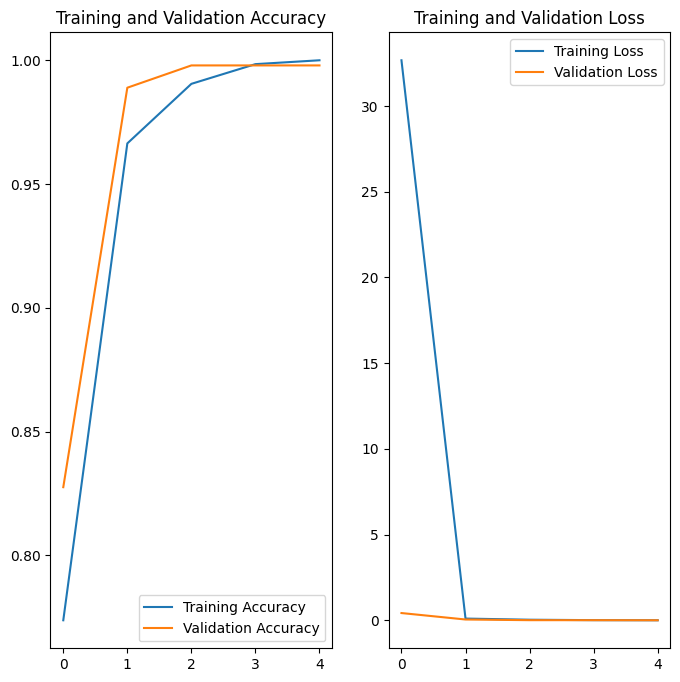

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Didapatkan model goodfit walaupun val accuracy terdapat indikasi gradient vanishing namun nilai loss val masih terlihat turun.

# Testing Model

Melakukan test modeling terhadap gambar baru yang berbeda dari data yang ada di dalam dataset.

In [73]:
test_image1 = r'D:\Hacktiv8\Milestone\Milestone 5\black-rot-of-grape-grape-1575457334.jpg'
test_image2 = r'D:\Hacktiv8\Milestone\Milestone 5\ESCA 1.jpg'
test_image3 = r'D:\Hacktiv8\Milestone\Milestone 5\leaf blight.jpg'
test_image4 = r'D:\Hacktiv8\Milestone\Milestone 5\Healthy-grape-leaf.jpg'
img1 = keras.preprocessing.image.load_img(
    test_image1, target_size=(IMG_HEIGHT,IMG_WIDTH)
)
img2 = keras.preprocessing.image.load_img(
    test_image2, target_size=(IMG_HEIGHT,IMG_WIDTH)
)
img3 = keras.preprocessing.image.load_img(
    test_image3, target_size=(IMG_HEIGHT,IMG_WIDTH)
)
img4 = keras.preprocessing.image.load_img(
    test_image4, target_size=(IMG_HEIGHT,IMG_WIDTH)
)

1/1 [==============================] - 1s 723ms/step
This image most likely belongs to Healthy with a 98.88 percent confidence.


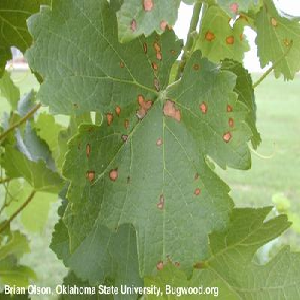

In [74]:
img_array = keras.preprocessing.image.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img1

Pada gambar diatas terlihat prediksi salah memprediksi gambar dikarenakan pada gambar diatas terlihat memiliki latar belakang yang tidak seragam sehingga model salah memprediksi gambar karena warna hijau pada latar belakang sangat mempengaruhi tingkat prediksi dari model ini.

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to ESCA with a 78.71 percent confidence.


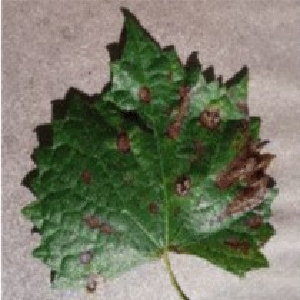

In [75]:
img_array = keras.preprocessing.image.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img2

Pada gambar diatas terlihat bahwa model benar memprediksi kelas karena pada gambar diatas memiliki latar belakang abu-abu dan objek berada diposisi tengah sehingga model dapat fokus kepada objek tersebut dan dapat menghasilkan prediksi yang lebih tinggi dan akurat.

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Leaf Blight with a 99.83 percent confidence.


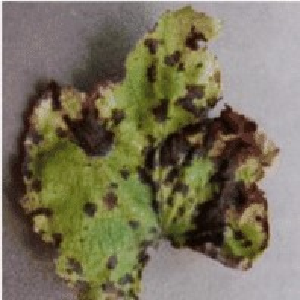

In [76]:
img_array = keras.preprocessing.image.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img3

Pada gambar diatas terlihat bahwa model benar memprediksi kelas karena pada gambar diatas memiliki latar belakang abu-abu dan objek berada diposisi tengah sehingga model dapat fokus kepada objek tersebut dan dapat menghasilkan prediksi yang lebih tinggi dan akurat.

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to Healthy with a 99.29 percent confidence.


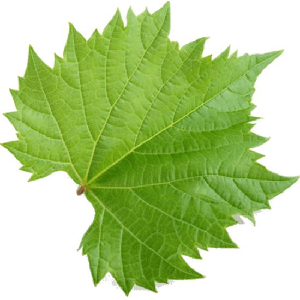

In [77]:
img_array = keras.preprocessing.image.img_to_array(img4)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img4

Pada gambar diatas terlihat bahwa model benar memprediksi kelas karena pada gambar diatas memiliki latar belakang putih dan objek berada diposisi tengah sehingga model dapat fokus kepada objek tersebut dan dapat menghasilkan prediksi yang lebih tinggi dan akurat.

In [78]:
results = model.evaluate(test_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.17696
Test Accuracy: 95.07%


Akurasi pada data test didapatkan nilai 95% dengan nilai loss 0.17%

# Model Save

In [82]:
joblib.dump(class_names,'class_names.pkl')
model.save('best_model.h5')

# Conclusion and Overall Conclusion

## Model Conclusion

Model training yang menggunakan activation relu dengan 8 hidden layer, Layer Output menggunakan softmax. Model menggunakan optimizer Adamax dengan metrik accuracy dan memiliki total parameter sebanyak 10 juta parameter.

Didapatkan akurasi dan val akurasi akhir sebesar 100% dan 99%, model adalah goodfit walaupun val accuracy terdapat indikasi gradient vanishing namun nilai loss val masih terlihat turun.

Model dengan tingkat akurasi dan val akurasi sebesar ini tidak diperlukan model improvement.

Model ini apabila dilakukan test pada gambar diluar dataset tidak dapat melakukan prediksi dengan baik apabila gambar tersebut memiliki latar belakang yang sama dengan objek prediksi serta memiliki latar belakang yang heterogen (terdapat banyak objek pada gambar) yang mengakibatkan model tidak dapat memprediksi dengan baik.

Sebaliknya, Model dapat memprediksi dengan sangat akurat apabila gambar memiliki latar belakang seragam namun tidak berwarna hijau (direkomendasikan warna abu-abu, hitam, atau putih).

## Overall Conclusion

Terdapat 4 Kondisi pada tumbuhan Anggur yaitu:
- Healthy,

- ESCA,

- Black Rot,

- Leaf Blight

Secara Overall Model dapat melakukan prediksi kondisi tumbuhan Anggur berdasarkan kondisi Daun Anggur dengan sangat baik, namun dengan beberapa catatan, yaitu:

- Model ini tidak dapat melakukan prediksi dengan baik apabila gambar tersebut memiliki latar belakang yang sama dengan objek prediksi serta memiliki latar belakang yang heterogen (terdapat banyak objek pada gambar) yang mengakibatkan model tidak dapat memprediksi dengan baik.

- Model dapat memprediksi dengan sangat akurat apabila gambar memiliki latar belakang seragam namun tidak berwarna hijau (direkomendasikan warna abu-abu, hitam, atau putih).

Impact yang akan ditimbulkan dengan adanya model ini adalah

- Mempermudah melakukan klasifikasi

- Semua orang dapat dengan mudah mengetahui kondisi tumbuhan anggur tersebut hanya dengan memoto kondisi daun anggur (dengan latar belakang selain warna hijau).

- Meningkatkan tingkat akurasi pengklasifikasian